In [1]:
# ВСЁ ЧТО НУЖНО ДЛЯ ЛАБЫ

# 1. ФУНКЦИЯ КВАНТОВАНИЯ
import numpy as np
def quantize(input, low=0, high=1, levels = 2):
    input = np.clip(input, low, high) # граница интервала квантования

    if isinstance(levels, int): # список уровней квантования из числа - количества этих уровней
        levels = np.linspace(low, high, levels+1) # список уровней квантования, например если 2 уровня квантования то [0, 0.5, 1], и 0 не считается
        between = [(levels[i]+levels[i+1])/2 for i in range(len(levels)-1)] # усреднённые значения уровней квантования, если 2 уровня квантования то 1 уровень между 0 и 0.5 = 0.25, второй уровень между 0.5 и 1 = 0.75.
        for i in range(len(levels)-1): input[input<=levels[i+1]] = int(2550*between[i]) # если 2 уровня то пиксели ниже 0.5 станут 0.25, а выше - 0.75
    
    else: # чтобы задать свои уровни для неравномерного квантования
        between = [(levels[i]+levels[i+1])/2 for i in range(len(levels)-1)] + [1] 
        for i in range(len(between)): input[input<=between[i]] = int(2550*levels[i])
    return (input/10).astype(np.uint8)

# АЛЬТЕРНАТИВНАЯ ФУНКЦИЯ КВАНТОВАНИЯ, МОЖНО ТОЖЕ ЕЁ ПОПРОВОБОВАТЬ
def quantize(input, low=0, high=1, levels=2):
    if isinstance(levels, int): levels = np.linspace(low, high, levels)
    return ((np.digitize(np.clip(input, low, high), levels))*(255/len(levels))).astype(np.uint8)


# 2. ФУНКЦИЯ УПОРЯДОЧЕННОГО ДИЗЕРИНГА БАЙЕРА
def bayer(image, matrix):
    image=image.copy().astype(float)
    # сначала берутся средние значения квадратов из 2*2 пикселя на изображении:
    image2 = np.repeat(np.repeat((image[1::2,1::2] + image[1::2, :-1:2] + image[:-1:2, 1::2] + image[:-1:2, :-1:2])/4, 2, axis=0), 2, axis=1)
    # Строчка выше может сделать разрешение изображений на 1 ниже по вертикали или горизонтали, потом не будут считаться MSE и т.д, чтобы сохранить разрешение я вставляю всё это в оригинал
    image[:image2.shape[0], :image2.shape[1]] = image2
    # дальше я сделал решетку из матриц Байера под размер изображения (можно также сделать циклом чтобы было по другому):
    matrix = np.tile(matrix/(np.max(matrix)/255), (image.shape[0] // matrix.shape[0] + 2, image.shape[1] // matrix.shape[1] + 2))[:image.shape[0], :image.shape[1]] 
    # пиксели больше решетки равны 255, меньше - 0, таким образом получается изображение с 2мя уровнями:
    image[image>=matrix]=255
    image[image<matrix]=0
    return image.astype(np.uint8) # И эта функция должна быть как альтернатива квантованию с 2 уровнями но лучше.


# 3. МЕТРИКИ (ВОЗЬМИТЕ ИЗ СВОЕЙ ПР1 ЕСЛИ ЕСТЬ)
def mse(image1, image2):
    return np.sum((np.abs(image1.astype(float) - image2.astype(float)))**2) / image1.size
def psnr(image1, image2):
    import math
    return 20 * math.log10(255/(mse(image1, image2)**0.5))
from skimage.metrics import structural_similarity as ssim

# КАКДЕЛАТЬ:
# Нужно взять три изображения из своего ПР1, по одному из каждой группы, и изображение синусоиды из своего ПР2. 

# Все изображения преобразовать в чёрно белый цвет, например image = cv2.cvtColor(cv2.imread('image.jpg'), cv2.COLOR_BGR2LAB)[:,:,0]

# Дальше при помощи функция квантования все изображения преобразовать до 2, 4, 16, 64, 128 уровней квантования, 
# и при помощи функции дизеринга ещё раз до 2 уровней, итого получится 24 изображения - 20 квантования и 4 дизеринга.
# и всех их нужно сравнить с оригиналами при помощи функций MSE, PSNR, SSIM.

# В итоге по всему этому нужно построить Графики зависимости показателей качества изображения от числа уровней квантования.

### Никишев И.О. 224-321 Лабораторная работа №2 Оценка влияния параметров квантования на точность передачи изображения

Цель

Оценить влияния параметров квантования на точность передачи
изображения с помощью показателей качества изображений.

Исходные данные: Три изображения из практического задания №2: по одному из каждой группы по количеству деталей. Изображения следует предварительно преобразовать в градации серого.


In [2]:
import cv2
images = [cv2.cvtColor(cv2.imread(a), cv2.COLOR_BGR2LAB)[:,:,0] for a in ('low.jpg', 'med.jpg', 'high.jpg', 'sine.png')] # преобразование в серый цвет


Используя функции для квантования сигнала из практического
задания №4 преобразовать четыре изображения уменьшив число
уровней до 2, 4, 16, 64, 128.

In [3]:
# Функция квантования
import numpy as np
def quantize(input, low=0, high=1, levels = 2):
    input = np.clip(input, low, high)

    if isinstance(levels, int):
        levels = np.linspace(low, high, levels+1) 
        between = [(levels[i]+levels[i+1])/2 for i in range(len(levels)-1)] 
        for i in range(len(levels)-1): input[input<=levels[i+1]] = int(2550*between[i])
    
    else: 
        between = [(levels[i]+levels[i+1])/2 for i in range(len(levels)-1)] + [1] 
        for i in range(len(between)): input[input<=between[i]] = int(2550*levels[i])
    return (input/10).astype(np.uint8)



# Метрики
def mse(image1, image2):
    return np.sum((np.abs(image1.astype(float) - image2.astype(float)))**2) / image1.size
def psnr(image1, image2):
    import math
    return 20 * math.log10(255/(mse(image1, image2)**0.5))
from skimage.metrics import structural_similarity as ssim

quantized = [[quantize(b.copy()/255, 0, 1, a) for a in [128, 64, 16, 4, 2]] for b in images.copy()]
msegraph = [[mse(images[a], quantized[a][b]) for b in range(5)] for a in range(4)]
psnrgraph = [[psnr(images[a], quantized[a][b]) for b in range(5)] for a in range(4)]
ssimgraph = [[ssim(images[a], quantized[a][b]) for b in range(5)] for a in range(4)]

Использовать функции дизеринга для получения дополнительных
изображений с двумя уровнями квантования.

Реализация метода заключается в том, что в исходном изображении
c поля 2 на 2 пикселя рассчитывается среднее значение светлоты. Затем
среднее значение сравнивается со значениями элементов пороговой матрицы. Если среднее превышает или равно значению элемента матрицы,
то пиксель становится светлым, в противном случае темным.

<Figure size 640x480 with 0 Axes>

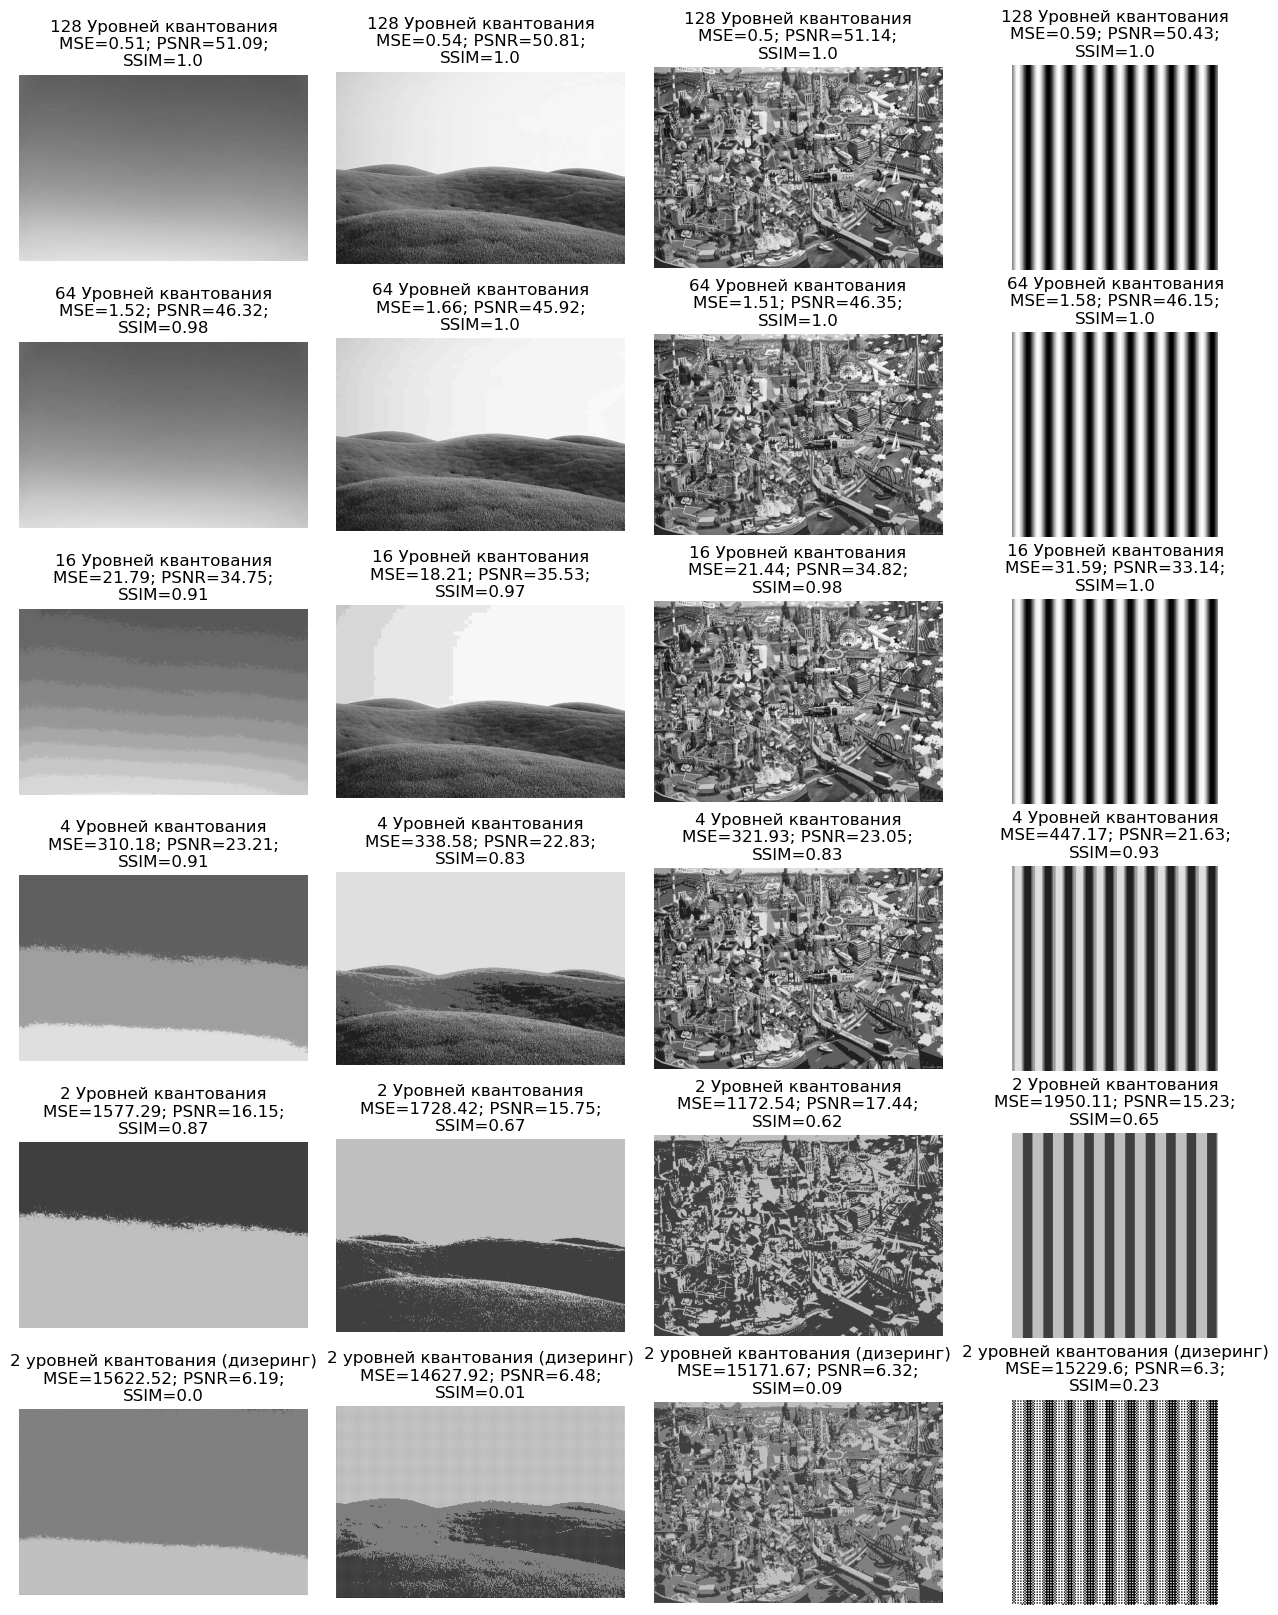

In [4]:
# Упорядоченный дизеринг
# def bayer(image, matrix):
#     matrix = np.tile(matrix/(np.max(matrix)/255), (image.shape[0] // matrix.shape[0] + 1, image.shape[1] // matrix.shape[1] + 1))[:image.shape[0], :image.shape[1]] # решетка размера изображения
#     image[image>=matrix]=255
#     image[image<matrix]=0
#     return image

# Упорядоченный дизеринг
def bayer(image, matrix):
    image=image.copy().astype(float)
    image2 = np.repeat(np.repeat((image[1::2,1::2] + image[1::2, :-1:2] + image[:-1:2, 1::2] + image[:-1:2, :-1:2])/4, 2, axis=0), 2, axis=1) # средние значения квадратов 2*2 пикселя
    image[:image2.shape[0], :image2.shape[1]] = image2
    matrix = np.tile(matrix/(np.max(matrix)/255), (image.shape[0] // matrix.shape[0] + 2, image.shape[1] // matrix.shape[1] + 2))[:image.shape[0], :image.shape[1]] # решетка из матриц Байера под размер изображения
    image[image>=matrix]=255
    image[image<matrix]=0
    return image.astype(np.uint8)

dithered = [bayer(a.copy(), np.array([[0,2],[3,1]])) for a in images.copy()]

import matplotlib.pyplot as plt
plt.figure()
a, b = plt.subplots(6,4)
for i, ax in enumerate(b.flatten()):
    if i >= 20: 
        ax.imshow(dithered[i%4], cmap='gray', vmin=0, vmax=255)
        ax.set_title(f'2 уровней квантования (дизеринг)\nMSE={round(mse(images[i%4], dithered[i%4]), 2)}; PSNR={round(psnr(images[i%4], dithered[i%4]), 2)};\nSSIM={round(ssim(images[i%4], dithered[i%4]), 2)}')
    else: 
        ax.imshow(quantized[i%4][i//4], cmap='gray', vmin=0, vmax=255)
        ax.set_title(f'{[128, 64, 16, 4, 2, 2][i//4]} Уровней квантования\nMSE={round(msegraph[i%4][i//4], 2)}; PSNR={round(psnrgraph[i%4][i//4], 2)};\nSSIM={round(ssimgraph[i%4][i//4], 2)}')
[a.set_axis_off() for a in b.ravel()]
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.gcf().set_size_inches(16, 20)


Графики зависимости показателей качества изображения от числа
уровней квантования

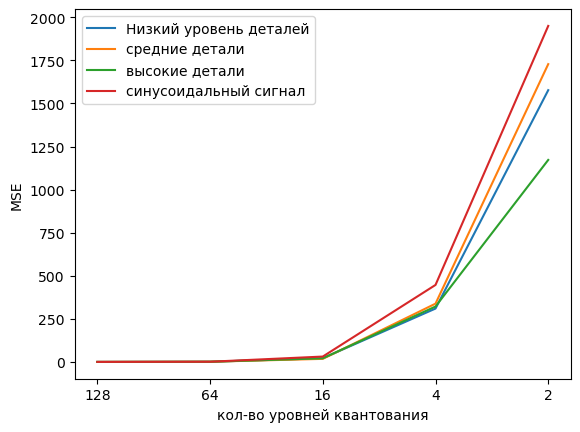

In [5]:
plt.plot(['128', '64', '16', '4', '2'],msegraph[0],label='Низкий уровень деталей')
plt.plot(['128', '64', '16', '4', '2'],msegraph[1],label='средние детали')
plt.plot(['128', '64', '16', '4', '2'],msegraph[2],label='высокие детали')
plt.plot(['128', '64', '16', '4', '2'],msegraph[3],label='синусоидальный сигнал')
plt.xlabel('кол-во уровней квантования')
plt.ylabel('MSE')
plt.legend()
plt.show()

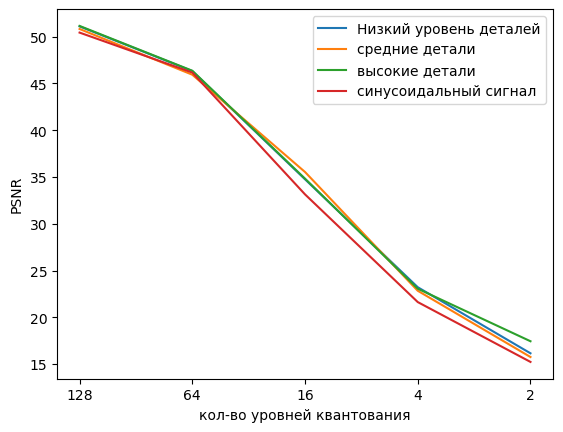

In [6]:
plt.plot(['128', '64', '16', '4', '2'],psnrgraph[0],label='Низкий уровень деталей')
plt.plot(['128', '64', '16', '4', '2'],psnrgraph[1],label='средние детали')
plt.plot(['128', '64', '16', '4', '2'],psnrgraph[2],label='высокие детали')
plt.plot(['128', '64', '16', '4', '2'],psnrgraph[3],label='синусоидальный сигнал')
plt.xlabel('кол-во уровней квантования')
plt.ylabel('PSNR')
plt.legend()
plt.show()

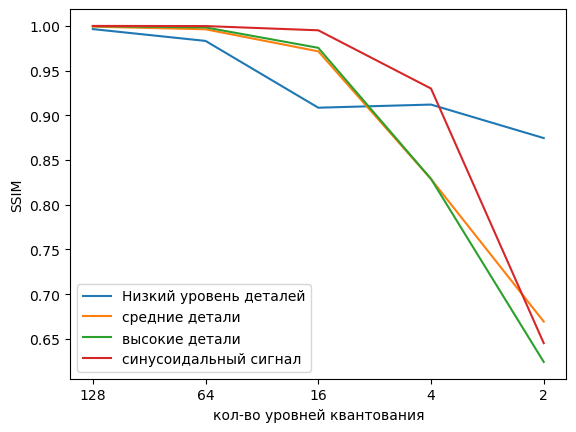

In [7]:
plt.plot(['128', '64', '16', '4', '2'],ssimgraph[0],label='Низкий уровень деталей')
plt.plot(['128', '64', '16', '4', '2'],ssimgraph[1],label='средние детали')
plt.plot(['128', '64', '16', '4', '2'],ssimgraph[2],label='высокие детали')
plt.plot(['128', '64', '16', '4', '2'],ssimgraph[3],label='синусоидальный сигнал')
plt.xlabel('кол-во уровней квантования')
plt.ylabel('SSIM')
plt.legend()
plt.show()

### Вывод
(a) Как меняются показатели качества от числа уровней квантования: При высоком значении количества уровней квантования уменьшение этого значения в два раза довольно слабо влияет на показатели. Это особенно заметно по минимальной разнице между показателями изображений, полученных квантованием с 128 и 64 уровнями. В то же время, разница между 4 и 2 уровнями макимальна в большинстве случаев.

(b) Позволяет ли дизеринг повысить качество и как при этом изменяются показатели качества: дизеринг позволяет повысить качество изображений, в особенности если изображения высокого разрешения и покрывают большую часть диапазона светлот. Решетка дизеринга позволяет передать пять уровней светлоты, используя лишь два уровня квантования, что видно на полученных изображениях. В то же время, если часть значений решетки выше всех значений пикселе изображения, эти значения не будут использоваться, следовательно стандартный метод дизеринга без неравномерного квантования неэффективен в таких случаях. Кроме того, как можно заметить на изображениях более низкого разрешения, если на изображении видны отдельные пиксели, то при использовании дизеринга будет видна структура матрицы Байера. Так как показатели качества не учитывают то, что на изображениях высокого разрешения структура матрицы Байера не видна, и видно некоторое усреднённое значение, одно из пяти значений, которые возможно вывести матрицей Байера размером 2x2, они оказываются значительно заниженными по сравнению с визуальной разницей между изображениями. Особенно это видно по показателю SSIM, так как он отражает структурную схожесть, и на маленьком масштабе, незаметном на изображениях высокого разрешения, дизеринг выглядит как максимально высоко-конрастные структуры, которых нет в оригинальном изображении.

(c) Соответствует ли изменение показателей качества изображений их субъективному визуальному восприятию. В целом, изменение показателей качества изображений соответствует их субъективному визуальному восприятию. Например, визуально сложно увиденть разницу между 128 и 16 уровнями квантования на изображении с высоким количеством деталей, поэтому его показатель SSIM значительно выше, а на изображениях со средними и низкими деталями проявляются заметные резкие переходы цвета в местах с градиентом, что подтверждаеся их более низким показателем SSIM. Показатели MSE и PSNR отражают тренд изменения качества изображений в целом, однако на них не отображается разница между изображениями с различным количеством деталей.